# Duplicate Bug Report Detection

TP initialement créé par Irving Muller Rodrigues pour le cours de fouilles de données de Montréal.

Date de remise: **08/11/2024 sur Moodle.**

Vous devez soumettre deux fichiers:

1. Ce notebook complété.
1. Le fichier `bug_reports.json` contenant les données extraites des pages web.

## 1 - Présentation

En raison de la complexité des systèmes logiciels, les bugs logiciels sont répandus.
Les entreprises, en particulier les grandes, utilisent généralement un système de suivi des bugs (BTS) pour gérer et suivre les enregistrements des bugs.
Outre les développeurs et les testeurs, de nombreux projets, principalement des projets open source, permettent aux utilisateurs de signaler de nouveaux bugs dans leur BTS.
Pour ce faire, les utilisateurs doivent remplir un formulaire avec plusieurs champs.
Un sous-ensemble important de ces champs fournissent des données catégorielles et n'acceptent que les valeurs qui vont d'une liste fixe d'options (par exemple, composant, version et produit du système).
Deux autres domaines importants sont le résumé et la description.
Les utilisateurs sont libres d'écrire quoi que ce soit dans les deux champs et la seule contrainte est que le résumé a un nombre maximum de caractères.
La soumission d'un formulaire crée une page, appelée rapport de bug ou rapport de problème, qui contient toutes les informations sur un bug.

Le manque de communication et de synchronisation font que les utilisateurs peuvent ne pas savoir qu'un bug spécifique a déjà été soumis et le signaler à nouveau.
Identifier les rapports de bugs en double est une tâche importante dans les BTS et c'est le sujet de ce TP.
Notre objectif est de développer un système qui prédit si une paire de rapports de bug soumis sont dupliqué ou non.
Ce système pourra être utilisé pour identifier automatiquement les rapports dupliqués.

## 2 - Setup

Pour ce TP, vous aurez besoin des librairies `numpy` et `sklearn`, ainsi que la librairie `nltk`, qui est une libraire utilisée pour faire du traitement du language (Natural Language Processing, NLP).

In [1]:
!pip install numpy scikit-learn nltk beautifulsoup4 lxml


import nltk
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3 - Les données / Data

Téléchargez l'archive sur Moodle et unzippez la.

L'archive contient les fichiers suivants :

1. training.txt : ce fichier contient des paires de rapports de bogues qui seront utilisés pour entraîner notre système.
2. validation.txt : Ce fichier contient des paires de rapports de bogues qui seront utilisés pour évaluer notre système.
2. bug_reports : Ce dossier contient le code HTML des bug reports. Chaque fichier HTML est nommé selon le motif **bug_report_id.html**.


L'image ci-dessous illustre un exemple de bug report:

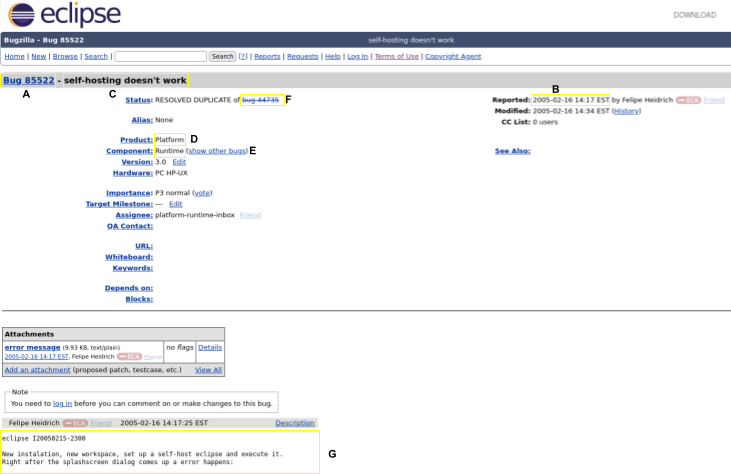

- A : identifiant du bug report
- B : date de création
- C : résumé
- D : produit
- E : composant
- F : l'identifiant du rapport dont le bug report est dupliqué
- G : description


Le script suivant charge le jeu de données de test et définit certaines variables globales:

In [2]:
# Les fichiers training.txt et validation.txt contiennent une paire d'id
# spécifiants deux reports et un label permettant de savoir si la paire
# est un duplicate (= 1) ou pas (= -1).
!unzip data.zip
!ls data/
!head ./data/training.txt

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/bug_reports/75817.html  
  inflating: data/bug_reports/186068.html  
  inflating: data/bug_reports/121692.html  
  inflating: data/bug_reports/17111.html  
  inflating: data/bug_reports/98599.html  
  inflating: data/bug_reports/137565.html  
  inflating: data/bug_reports/21495.html  
  inflating: data/bug_reports/190780.html  
  inflating: data/bug_reports/29083.html  
  inflating: data/bug_reports/7913.html  
  inflating: data/bug_reports/75375.html  
  inflating: data/bug_reports/168597.html  
  inflating: data/bug_reports/178669.html  
  inflating: data/bug_reports/14210.html  
  inflating: data/bug_reports/70612.html  
  inflating: data/bug_reports/165756.html  
  inflating: data/bug_reports/201554.html  
  inflating: data/bug_reports/12957.html  
  inflating: data/bug_reports/137673.html  
  inflating: data/bug_reports/205537.html  
  inflating: data/bug_reports/180759.html  
  inflati

In [2]:
from pathlib import Path


def read_dataset(file: Path) -> list:
    dataset = []
    with open(file, "r") as data:
        for line in data:
            line = line.strip()

            if len(line) == 0:
                continue

            rep1, rep2, label = line.split(',')

            rep1 = int(rep1)
            rep2 = int(rep2)
            label = 1.0 if int(label) > 0 else 0.0

            dataset.append( (rep1, rep2, label) )

    return dataset


FOLDER_PATH = Path("./data/")
PAGE_FOLDER = FOLDER_PATH / "bug_reports/"

training_file = FOLDER_PATH / "training.txt"
validation_file = FOLDER_PATH / "validation.txt"

training_pairs = read_dataset(training_file)
validation_pairs = read_dataset(validation_file)

training_pairs[:5]

[(27227, 18431, 1.0),
 (79272, 115069, 0.0),
 (160452, 173324, 0.0),
 (8149, 48097, 0.0),
 (143594, 76868, 0.0)]

## 4 - Web scraping (4.5 points)

"Le *web scraping* (parfois appelé harvesting) est une technique d'extraction du contenu de sites Web, via un script ou un programme, dans le but de le transformer pour permettre son utilisation dans un autre contexte, par exemple le référencement." [Wikipedia](https://fr.wikipedia.org/wiki/Web_scraping)

**Implémentez la fonction `extract_data_from_page` qui extrait les informations suivantes du code HTML: l'ID du bug report, la date de création, le titre, le produit, le composant, l'ID du bug report dont il est un duplicata, et la description.**

La fonction `extract_data_from_page` retourne un dictionnaire avec la structure suivante:

```python
 {"report_id": int,
  "dup_id": int or None (the report id which it is duplicate),
  "component": string,
  "product": string,
  "summary": str,
  "description": string,
  "creation_date": string}
```

Par exemple, pour le bug report "bug_report/18431.html", la fonction *extract_data_from_page* retourne:

```python
{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT'}
```
**Remarques:**

- La date de création doit être représentée sous la forme d'un "année-mois-jour heure:minute fuseau horaire". Si un bug report n'est pas un duplicata, alors dup_id doit être None.
- Indice: [lxml parse](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#installing-a-parser) est plus rapide que html.parser.
- Il est plus facile de lire le code HTML directement depuis un navigateur en mode inspection.
- Les champs nécessaires pour continuer le TP sont les suivants : `report_id`, `component`, `product`, `summary`, `description`. Si vous n'arrivez pas à extraire les autres champs, vous n'aurez pas tous les points associés à cette question mais vous pourrez continuer le TP.

In [3]:
from bs4 import BeautifulSoup


def extract_data_from_page(pagepath: Path) -> dict:
    """Scrap le contenu du rapport de HTML.

    ---
    Args:
        pagepath: Le chemin du fichier HTML.

    ---
    Returns:
        Les données extraites de la page HTML:
            {
                "report_id": int,
                "dup_id": int or None (l'identifiant du rapport dont il est dupliqué),
                "component": string,
                "product": string,
                "summary": string,
                "description": string,
                "creation_date": string
            }
    """
    with open(pagepath, "r") as page:
        soup = BeautifulSoup(page, "lxml")

        form = soup.find("form", {'name': 'changeform'})
        if form:
            input_element = form.find("input", {'name': 'id'})
            if input_element:
                report_id = int(input_element['value'])
            else:
              report_id = None
        dup_id = None
        a = soup.find("a", {'class': 'bz_bug_link'})
        if a:
          dup_id_text = a.text.replace("bug ", "").strip()
          if dup_id_text.isdigit():
              dup_id = int(dup_id_text)

        td1 = soup.find("td", {'id': 'field_container_component'})
        if td1:
          component = td1.text
          component = component.replace("(show other bugs)", "")
        else:
          component = None

        td2 = soup.find("td", {'id': 'field_container_product' })
        if td2:
          product = td2.text
        else:
           product = None

        span1 = soup.find("span", {'id': 'subtitle'})
        if span1:
          summary = span1.text

        else:
          summary = None

        pre = soup.find("pre", {"class": "bz_comment_text"})
        if pre:
          description = pre.text
        else:
          description = None

        td3 = soup.find("td", {"id": "bz_show_bug_column_2"})
        if td3:
          position = td3.text.find("Reported:")
          if position != -1:
            creation_date = td3.text[position + 15:]
            creation_date = creation_date[:20]

        else:
          creation_date = None

        component = component.replace("\n","")
        component = component.strip()
        product = product.replace("\n","")
        product = product.strip()

    dict = {
            "report_id": report_id,
            "dup_id": dup_id,
            "component": component,
            "product": product,
            "summary": summary,
            "description": description,
            "creation_date": creation_date
            }
    return dict

extract_data_from_page(PAGE_FOLDER / "18431.html")

{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline po

### Extraction de texte à partir de HTML / Text extraction from HTML


In [4]:
import json
import os
from multiprocessing import Pool, TimeoutError
from time import time

from tqdm.notebook import tqdm

# Indexer chaque rapport par son identifiant
index_path = FOLDER_PATH / "bug_reports.json"

if not index_path.exists():
    paths = [p for p in PAGE_FOLDER.glob("*")]
    reports = [
        extract_data_from_page(p)
        for p in tqdm(paths, "Extracting data")
    ]
    report_index = {
        r["report_id"]: r
        for r in reports
    }

    # Sauvegarde l'extraction pour ne pas avoir a la refaire les prochaines fois.
    with open(index_path, "w") as index_data:
        json.dump(report_index, index_data)
else:
    # Charge une existante sauvegarde.
    with open(index_path, "r") as index_data:
        report_index = json.load(index_data)

    report_index = {
        int(v): r for v, r in report_index.items()
    }

## 5 - Prétraitement des données / Data preprocessing

Le prétraitement des données est une tache cruciale en machine learning. Cette étape nettoie et transforme les données brutes dans un format qui permet leur analyse, et leur utilisation avec des algorithmes de *machine learning*. En traitement des langages (natural language processing, NLP) on utilise très souvent les méthodes de *tokenization* et de *stemming*. De plus, vous implémenterez une étape supplémentaire pour filtrer les mots sans importance.

### 5.1 - Tokenization (1 point)

Cette étape permet de séparer un texte en séquence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple, la phrase `"It's the student's notebook."` peut être séparé en liste de tokens de cette manière: `["it", "s", "the", "student", "s", "notebook"]`.

**Implementez `tokenize_space_punk` qui remplace la ponctuation par un espace, puis tokenise les jetons séparés par des espaces (espace, tabulation, nouvelle ligne). Tous les tokenizers doivent mettre les jetons en minuscule.**

In [5]:
import string


def tokenize_space_punk(text: str) -> list[str]:
    """This tokenizer replaces punctuation and whitespace to spaces and then
    tokenizes the tokens that are separated by spaces.

    Punctuation characters can be found here: https://docs.python.org/3/library/string.html#string.punctuation
    Whitespaces are here: https://docs.python.org/3/library/string.html#string.whitespace
    """

    for punct in string.punctuation:
        text = text.replace(punct, ' ')

    text = ' '.join(text.split())
    tokens = text.split(' ')
    tokens = [token.lower() for token in tokens]

    return tokens

    pass

tokenize_space_punk("It's the student's notebook.")

['it', 's', 'the', 'student', 's', 'notebook']

### 5.2 - Stop words removal (1 point)

Certains tokens sont sans importance pour la comparaison, car ils apparaissent dans la majorité des discussions. Les supprimer réduit la dimension du vecteur et accélère les calculs. On appel ces mots des [stop words](https://en.wikipedia.org/wiki/Stop_word).

**Implémentez la fonction `filter_tokens` qui retire ces mots de la liste des tokens.**

*Vous devriez utiliser un ensemble de mots prédéfini.*

In [6]:
from nltk.corpus import stopwords


def filter_tokens(tokens: list[str]) -> list[str]:
  stop_words = set(stopwords.words('english'))

  filtered_tokens = [token for token in tokens if token not in stop_words]
  return filtered_tokens


  pass

filter_tokens(['it', 's', 'the', 'student', 's', 'notebook'])

['student', 'notebook']

### 5.3 - Stemming (1 point)

La racinisation (stemming) est un procédé de transformation des flexions en leur radical ou racine. Par example, en anglais, la racinisation de "fishing", "fished" and "fish" donne "fish" (stem).

In [7]:
from nltk.stem.snowball import SnowballStemmer


def stem_tokens(tokens: list[str]) -> list[str]:
    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens
    pass


print(stem_tokens(['I', 'tried', 'different', 'fishes']))
print(stem_tokens(['I', 'will', 'try', 'only', 'one', 'fishing']))

['i', 'tri', 'differ', 'fish']
['i', 'will', 'tri', 'onli', 'one', 'fish']


### Question (0.5 point)


**Expliquez comment et pourquoi le stemming est utile à notre système.**

Le stemming est utile à notre système en transformant les mots en leur radical afin d'améliorer les performances de traitement de texte. Cela permet de réduire la complexité des données.

## 6 - Représentation des données / Data Representation (5 points)


### Bag of Words (BoW)

De nombreux algorithmes demandent des entrées qui sont toutes de la même taille. Cela n'est pas toujours le cas, notamment pour des données textuelles qui peuvent avoir un nombre variable de mots.

Par exemple, considérons la phrase 1, ”Board games are much better than video games” et la phrase 2, ”Monopoly is an awesome game!” La table ci-dessous montre un exemple d'un moyen de représentation de ces deux phrases en utilisant une représentation fixe :

|            | an | are | ! | monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |


Chaque colonne représente un mot du vocabulaire (de longueur 13), tandis que chaque ligne contient l'occurrence des mots dans une phrase. Ainsi, la valeur 2 à la position (1,7) est due au mot "*games*" qui apparaît deux fois dans la phrase 1.

Chaque ligne étant de longueur 13, on peut les utiliser comme vecteur pour représenter les phrases 1 et 2. C'est cette méthode que l'on appelle *Bag-of-Words* : une représentation de documents par des vecteurs dont la dimension est égale à la taille du vocabulaire, et qui est construite en comptant le nombre d'occurrences de chaque mot. Chaque token est ici associé à une dimension.

*Pour plus de simplicité, nous considérons un token et un mot comme interchangeable ici.*

In [8]:
from typing import Counter
import numpy as np


class BoW:
    vocab: dict[str, int]

    def fit(self, X: list[list[str]], max_vocab_size: int = 10_000):
        """Détermine les mots les plus fréquents et les ajoutent dans le
        dictionnaire de vocabulaire en leur assignant un id unique à chacun.

        ---
        Args:
            X: Liste de phrases tokenisées.
            max_vocab_size: Taille maximale du vocabulaire. Le vocabulaire ne
                garde que les tokens les plus fréquents et ignore le reste.
        """
        all_words = [word for sentence in X for word in sentence]

        word_counts = Counter(all_words)


        most_common_words = word_counts.most_common(max_vocab_size)

        self.word_to_id = {word: idx for idx, (word, _) in enumerate(most_common_words)}
        self.id_to_word = {idx: word for word, idx in self.word_to_id.items()}
        self.vocab_size = len(self.word_to_id)

        pass

    def transform(self, tokens: list[str]) -> np.ndarray:
        """Transform la liste de tokens en un vecteur de la taille du vocabulaire.

        ---
        Args:
            tokens: La liste de tokens à vectoriser.

        ---
        Returns:
            Le vecteur correspondant.
        """
        vector = np.zeros(self.vocab_size, dtype=int)

        for token in tokens:
            if token in self.word_to_id:
                vector[self.word_to_id[token]] += 1

        return vector

        pass

X = [
    ["Board", "games", "are", "much", "better", "than", "video", "games"],
    ["Monopoly", "is", "an", "awesome", "game", "!"],
]

bow = BoW()
bow.fit(X)
bow.transform(X[0])

array([2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

## 7 - Pipeline (3 points)

La *pipeline* est la séquence d'étapes de prétraitement des données qui transforme les données brutes dans un format qui permet leur analyse.

Toutes les briques ont été codées, nous pouvons désormais traiter nos données
afin de vectoriser nos données textuelles. Pour cela, vous allez:

1. Tokeniser les résumés et descriptions de chaque rapport.
1. Appliquer le stemming aux tokens.
1. Entraîner un Bag-of-Words.
1. Appliquer le Bag-of-Words sur les tokens de description et résumé afin de les vectoriser.

Les représentations vectorielles finales doivent être stockées dans `report_index`, sous le nom `"description_vec"` et `"summary_vec"`.

**Vous devez implémenter la pipeline en suivant les instructions dans les cellules ci-dessous.**

In [9]:
"""Étape 1.
Tokeniser et supprimer les mots vides dans le résumé et la description de chaque
rapport.
"""



def tokenize_and_filter(report: dict) -> dict:
  summary_token = tokenize_space_punk(report['summary'])
  desc_token = tokenize_space_punk(report['description'])

  report['summary_token'] = filter_tokens(summary_token)
  report['desc_token'] = filter_tokens(desc_token)

  return report

processed_reports = []
for report in tqdm(report_index.values(), desc="Traitement des rapports"):
    processed_reports.append(tokenize_and_filter(report))

Traitement des rapports:   0%|          | 0/35072 [00:00<?, ?it/s]

In [10]:
"""Étape 2.
Appliquez le stemming aux jetons générés à partir de l'étape 1.
"""
def stem_report_tokens(report: dict) -> dict:
    """Applique le stemming aux jetons du résumé et de la description d'un rapport."""
    if 'summary_token' in report and 'desc_token' in report:
        report['summary_token'] = stem_tokens(report['summary_token'])
        report['desc_token'] = stem_tokens(report['desc_token'])

    return report

stemmed_reports = []
for report in tqdm(processed_reports, desc="Application du stemming"):
    stemmed_reports.append(stem_report_tokens(report))


Application du stemming:   0%|          | 0/35072 [00:00<?, ?it/s]

In [18]:
"""Étape 3.
Apprenez le Bag-of-Words en utilisant le résumé et la description de tous les
rapports dans le ensemble d'entraînement. Vous devez concaténer le contenu de
ces deux champs.

L'entrée de cette étape doit être la sortie de l'étape 3 (stemmed tokens).
"""
concatenated_reports = [" ".join(report['summary_token'] + report['desc_token']) for report in stemmed_reports]



bow = BoW()
bow.fit(concatenated_reports)

vectors = np.array([bow.transform(reports) for reports in tqdm(concatenated_reports, desc="Transformation des rapports", unit="rapport")])


Transformation des rapports:   0%|          | 0/35072 [00:00<?, ?rapport/s]

In [19]:
"""Étape 4.
Générez la représentation TF-IDF du résumé et de la description pour chaque
rapport.

L'entrée de cette étape doit être la sortie de l'étape 3 (stemmed tokens).
"""
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_features=20000, min_df=5)


print("Calcul de la représentation TF-IDF...")
tfidf_matrix = vectorizer.fit_transform(concatenated_reports)

print("Forme de la matrice TF-IDF :", tfidf_matrix.shape)

Calcul de la représentation TF-IDF...
Forme de la matrice TF-IDF : (35072, 16749)


## 8 - Cosine Similarity (2 points)

En NLP, la similarité cosinus est une fonction de similarité populaire utilisée pour comparer les vecteurs de documents. Cette fonction mesure à quel point la direction de deux vecteurs est différente et ses valeurs sont comprises entre -1 et 1.

La similarité en cosinus est définie comme:
\begin{equation}
    \operatorname{cos(v, v')} = \frac{\sum_{i=1}^{n} v_i  v_i'}{\sqrt{\sum_{i=1}^{n} v_i^2} \sqrt{\sum_{i=1}^{n}v_i'^2}},
\end{equation}
where $v$ and $v'$ sont des vecteurs de $n$ dimensions.

**Vous devez implémenter la fonction `cosine_similarity`.**

*Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy. De plus, si le dénominateur est zéro, alors vous devez considérer que cos(.) = 0*

In [20]:
from scipy.sparse import csr_matrix
def cosine_similarity(v1: np.ndarray, v2: np.ndarray) -> float:
    """Compute the cosine similarity between r1 and r2.

    ---
    Args:
        v1: Vector 1.
        v2: Vector 2.

    ---
    Returns:
        The cosine similarity between the two vectors.
    """
    v1_dense = v1.toarray()[0] if isinstance(v1, csr_matrix) else v1
    v2_dense = v2.toarray()[0] if isinstance(v2, csr_matrix) else v2

    dot_product = np.dot(v1_dense, v2_dense)


    norm_v1 = np.linalg.norm(v1_dense)
    norm_v2 = np.linalg.norm(v2_dense)


    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0


    return dot_product / (norm_v1 * norm_v2)
    pass

cosine_similarity(np.array([1, 2, 3]), np.array([4, 5, 6]))

0.9746318461970762

## 9 - Extraction de features / Feature extraction (1 point)

Nous formons un modèle de régression logistique pour prédire si une paire de rapports est dupliqué ou non. Les features utilisées pour la classification sont énumérées ci-dessous :

1. Cosine similarity entre les deux résumés.
1. Cosine similarity entre les deux descriptions.
1. Booléen valant 1 si les deux rapports proviennent des mêmes composants.
1. Booléen valant 1 si les deux rapports proviennent des mêmes produits.

**Implémentez ```extract_features``` qui extrait les features ci-dessus à partir d'une paire de rapports.**

In [21]:
def extract_features(r1: dict, r2: dict) -> np.ndarray:
    """Extrait les features d'une paire (r1, r2).

    ---
    Args:
        r1: Dictionnaire qui contient toutes les informations sur un rapport.
        r2: Dictionnaire qui contient toutes les informations sur un rapport.

    ---
    Returns:
        Vecteur de features contenant:
            - Cosine similarity entre les deux descriptions.
            - Cosine similarity entre les deux résumés.
            - Binaire permettant de savoir si les deux components sont les mêmes.
            - Binaire permettant de savoir si les deux produits sont les mêmes.
    """
    r1_id = r1['report_id']
    r2_id = r2['report_id']

    report_ids = list(report_index.keys())
    index1 = report_ids.index(r1_id)
    index2 = report_ids.index(r2_id)


    cos_sim_desc = cosine_similarity(tfidf_matrix[index1], tfidf_matrix[index2])


    cos_sim_sum = cosine_similarity(tfidf_matrix[index1], tfidf_matrix[index2])


    same_component = int(r1.get('component') == r2.get('component'))
    same_product = int(r1.get('product') == r2.get('product'))


    features = np.array([cos_sim_desc, cos_sim_sum, same_component, same_product])

    return features


    pass

id1, id2, _ = training_pairs[0]
extract_features(
    report_index[id1],
    report_index[id2],
)

array([0.74026876, 0.74026876, 1.        , 1.        ])

## 10 - Entraînement/Training (1 point)

Vous pouvez maintenant extraire les features du jeu d'entraînement et de test.

Entraînez un modèle de regression logistique et évaluez le sur les deux jeux de données. Affichez aussi la matrice de confusion.

*Vous devriez obtenir au moins 90% d'accuracy sur les deux jeux de données.*

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [23]:
features_list = []
y = []


for id1, id2, is_duplicate in tqdm(training_pairs, desc="Extraction des features"):
    r1 = report_index[id1]
    r2 = report_index[id2]


    features = extract_features(r1, r2)


    features_list.append(features)
    y.append(is_duplicate)


X_features = np.array(features_list)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy2 = accuracy_score(y_train, model.predict(X_train))
print(f'Accuracy train: {accuracy2 * 100:.2f}%')
print(f'Accuracy test: {accuracy * 100:.2f}%')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice de Confusion")
plt.show()

Extraction des features:   0%|          | 0/24534 [00:00<?, ?it/s]

Accuracy train: 92.31%
Accuracy test: 91.75%
